# COGS 108 - EDA Checkpoint

# Names

*   Naval Patel
*   Ray Zhou
*   Nathaniel Satriya
*   Yoomin Oh
*   Jennifer Nunez


<a id='research_question'></a>
# Research Question

Is there a correlation between population density (people per square mile) and depression per capita and square mile in the State of California between the years 2000-2020?



# Dataset(s)

1. Dataset name: Historical Population Density Data (1910-2020)

*   Link: https://www.census.gov/data/tables/time-series/dec/density-data-text.html
*   Number of Observations: 684
*  This data provides the changing resident populations of each state in the US over 12 decades and ranks them based on their population density. Density is measured as the average population per square mile. According to the US Census Bureau, density levels have been higher across the Eastern sea and pacific coastline and lower in most of the West.


2. Dataset name: County Population Totals: 2010-2019 (California) 
*   Link: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html
*   Number of Observations: 58
* This provides the annual population estimates for each county in California from 2010 to 2019.


3. Dataset name: California Individuals by mental health diagnosis, gender, age, race, ethnicity and veteran status: Number, 2014-2019
*  Link:https://www.samhsa.gov/data/sites/default/files/reports/rpt35253/MHCLD-2019-R-FINAL.pdf
*   Number of Observations: 10
* This table was pulled from the 2019 Mental Health Client-Level Data (MH-CLD) Annual Report by SAMHSA, the agency within the U.S Department of Health and Human Services. Specifically, it provides information reported from state administrative data systems on: mental health diagnoses, mental health treatment settings, and demographic and substance use characteristics of individuals in mental health treatment facillities. Since our state of interest is California we pulled a relevant table from this report.

4. Dataset name: Diagnosed Depression (Ever) in LA county
* Link:http://publichealth.lacounty.gov/ha/HA_DATA_TRENDS.htm
* Number of Observations: 27
* This dataset provides estimates of depression diagnoses in health districts part of Los Angeles county jurisdiction, from 1999 to 2018. It contains other information about race, ethnicity, age group, poverty level, gender and education. The county of LA notes: "We are happy to provide the following data from the 2018 Los Angeles County Health Survey. Please note that the disparities seen in the results for the different groups shown in the table are to a large degree driven by inequities in the social, economic, and environmental conditions experienced by these groups."

5. Dataset name: 
General Population Cities & Unincorporated Communities
Los Angeles County (1990 through 2020 Census)
* Link: http://www.laalmanac.com/population/po03.php
* Number of Observations: 142
* Population estimates for cities in LA county sourced from Census data.

# Setup

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import io
import csv
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

# Data Cleaning

* Every dataset was standardized to be lowercase, stripped of whitespace and punctuation, and drop empty values. This will make methods and operations function smoothly.

In [2]:
# Standardization functions
def remove_comma(output):
  if "," in output:
    output = output.replace(',', '')   
  return output

def remove_period(str_in):
  output = str_in
  try:
    output = str_in.lower()
    output = output.replace('.', '')
  except:
    output = str_in
    print("error")
  return output

def remove_dash(output):
  if "-" in output:
    output = output.replace('-','')
  return output

def remove_asterik(output):
  if "*" in output:
    output = output.replace('*', '')  
  return output

* Census data was fairly tidy already, but it included a lot of unecessary variables, so we filtered everything to focus on California observations starting from the years 2000 and forward.

* To narrow our focus we decided to extract California population counts and estimates. We will use this dataset to compare California mental health case estimates over the years 2000 to 2020.

In [3]:
# reading Historical Population Density Data (1910-2020) data from github 

population_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/apportionment.csv'
df1 = pd.read_csv(population_url)   # Original shape of this data, starting from 1910, is (684,10)                                   

# Drop all years except for 2000-2020
pop = df1.loc[(df1['Year'] >= 2000)]
#pop.shape                                        # After filtering it to only contain the 2000s the shape is (171,10)

# Focus on states and drop observations with Regions & Nations 
population = pop[pop['Geography Type'].str.contains("State")]

# Create a dataframe that focuses on the states & rename 'Geography Type' column to 'State'
population = population.rename(columns={'Name': 'name', 'Geography Type':'state', 'Year': 'year', 'Resident Population': 'res_pop_count', 'Percent Change in Resident Population': 'perc_change_res_pop', 'Resident Population Density': 'res_pop_density', 'Resident Population Density Rank': 'res_pop_density_rank'})
population = population.drop(population.columns[7:10], axis=1)
population = population.replace(',', '', regex=True)
population = population.astype({"res_pop_count": int, "perc_change_res_pop": float, "res_pop_density": float, "res_pop_density_rank": float})
# Filtered all states except California
population = population[population.name == 'California']
population = population.reset_index(drop=True)
population['state'] = population['state'].str.lower()
population['name'] = population['name'].str.lower()
population.head()


,name,state,year,res_pop_count,perc_change_res_pop,res_pop_density,res_pop_density_rank
0,california,state,2000,33871648,13.8,217.4,14.0
1,california,state,2010,37253956,10.0,239.1,13.0
2,california,state,2020,39538223,6.1,253.7,13.0


* The counties dataset needed all of its columns to be renamed to their respective variables.
* Initially we aimed to work with all counties in California, but based on available data we narrowed our scope to Los Angeles County. 

In [4]:
# California counties population totals from 2010-2019

counties_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/CA_counties_pop.csv'
df3 = pd.read_csv(counties_url)

# rename columns
df3 = df3.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)': 'county',
                          'Unnamed: 1':'census', 'Unnamed: 2': 'estimates',
                          'Unnamed: 3': '2010',
                          'Unnamed: 4': '2011',
                          'Unnamed: 5': '2012',
                          'Unnamed: 6': '2013', 'Unnamed: 7': '2014',
                          'Unnamed: 8': '2015', 'Unnamed: 9': '2016',
                          'Unnamed: 10': '2017', 'Unnamed: 11': '2018',
                          'Unnamed: 12': '2019'})
# drop unneeded rows
df3.drop(
    labels = [0,1,2,62,63,64,65,66],
    axis = 0,
    inplace=True
)
df3 = df3.reset_index(drop=True)

# standardize county names to lowercase and remove unecessary punctuations
df3['county'] = df3['county'].apply(remove_period)
#Remove state
df3['county'] = df3['county'].apply(lambda str_in: str_in.replace(', california', ''))
#Remove commas
df3 = df3.applymap(lambda str_in: str_in.replace(',', ''))
df3.drop(labels = 0, axis=0, inplace = True)


#iterate remove_comma function to columns
for i in range(0,10):
  temp = 2010 + i
  temp = str(temp)
  df3[temp] = df3[temp].apply(remove_comma)
df3['census'] = df3['census'].apply(remove_comma)
df3['estimates'] = df3['estimates'].apply(remove_comma)

# store la county information in its own variable
la = df3.loc[df3['county'] == 'los angeles county']

la



,county,census,estimates,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
19,los angeles county,9818605,9819968,9823246,9876482,9935375,9992484,10040072,10085416,10105708,10103711,10073906,10039107


* Mental health data for the state of California was extracted from SAMHSA report and rewritten as a csv file using the tabulate method. 
* Columns were renamed for better understandability and values were standardized.

In [5]:
from pandas.core.arrays import string_
# California individuals counted by type of mental health diagnosis through the years 2014-2019

box = [1,2,7,9]                            # Table measurements from PDF document [top, left, bottom, width]
cm_to_pdf = 28.28                          # Converts our margin measurements from cm to pdf points
for i in range(0,len(box)):
  box[i] *= cm_to_pdf
mh_url = 'https://www.samhsa.gov/data/sites/default/files/reports/rpt35253/MHCLD-2019-R-FINAL.pdf'
# df2 = tabula.read_pdf(mh_url, pages='438') # Using tabulate to read pdf

# *Convert this tabulated data to CSV (This portion will be commented out for faster shell processing)
# tabula.convert_into(mh_url, "mh.csv", pages="438", output_format="csv", stream=True)
# !cat mh.csv 

mh_url2 = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/mh.csv'
df2 = pd.read_csv(mh_url2)

# rename columns
df2 = df2.rename(columns={'Selected characteristics': 'disorder_type',
                          'Unnamed: 1':'totals', '2014': '2014',
                          '2015': '2015', '2016': '2016',
                          '2017': '2017', '2018': '2018',
                          '2019': '2019'})

# Copy disorder types to new dataframe
mh_disorders = df2.iloc[0:13, :]

# Make gender into its own df  *may delete
mh_genders = df2.iloc[13:17, :] 

# Make age its own df *may delete
mh_ages = df2.iloc[18:33, :]

# Clean NaN values for disorder types df
mh_disorders = mh_disorders.drop('totals',1)
mh_disorders = mh_disorders.dropna(axis=0)
mh_disorders = mh_disorders.reset_index(drop=True)

#iterate remove_comma function to columns
for i in range(0,6):
  temp = 2014 + i
  temp = str(temp)
  mh_disorders[temp] = mh_disorders[temp].apply(remove_comma)

def remove_dash(output):
  if "-" in output:
    output = output.replace('-','')
  return output

mh_disorders['disorder_type'] = mh_disorders['disorder_type'].str.lower()
mh_disorders['disorder_type'] = mh_disorders['disorder_type'].apply(remove_dash)

mh_disorders
# Move totals to bottom


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,disorder_type,2014,2015,2016,2017,2018,2019
0,total individuals,697180,695815,647328,638394,708521,742725
1,trauma and stressorrelated disorders,107725,111807,105263,95751,110463,119469
2,anxiety disorders,75243,82479,81052,89225,109679,114954
3,attention deficit/hyperactivity disorder,52189,51489,47165,46369,49613,48632
4,mood disorders,308348,309996,271061,196965,243123,261427
5,bipolar disorders,113612,112390,99012,51718,60772,62227
6,depressive disorders,196785,199698,173975,146363,183711,200791
7,personality disorders,24234,23816,21994,14570,12654,10520
8,psychotic disorders,126411,126516,116156,116861,137630,137726
9,alcohol or substancerelated disorders,113129,112757,92537,64358,70782,68319


* Irrelevant information was removed and columns were renamed for better understanding.
* Standardized and converted to numerical values

In [6]:
# Los Angeles mental health data 
la_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/la_demos_cleaned.csv'
df4 = pd.read_csv(la_url, index_col=0)
# We want to drop the index name because it is not useful
df4.index.name = None
# We will now reset the index column and removing unhelpful values
df4 = df4.T.reset_index().reset_index(drop=True)
# Renaming columns that have incorrect labels
df4 = df4.rename(columns={'index': 'year'})
# Removing percentage symbol throughout the DataFrame
df4 = df4.replace('%', '', regex=True)
# Convering DataFrame to numeric values
df4 = df4.apply(pd.to_numeric)
# Properly formatting years in datetime format so Seaborn doesn't convert the years to floats
df4['year'] = pd.to_datetime(df4.year.astype(str), format="%Y")
# Renaming 'LA Overall' column to be more descriptive about what the data is telling us
overall = df4.rename(columns={'LA Overall': 'population_depression_diagnosis_percent'})
# The overall LA county data is in the first few rows so we are using a subset of the data
overall = overall.iloc[:, 0:2]

df4


,year,LA Overall,Alhambra,Antelope Valley,Bellflower,Central,Compton,East LA,East Valley,El Monte,Foothill,Glendale,Harbor,Hollywood/Wilshire,Inglewood,Long Beach,Northeast,Pasadena,Pomona,San Antonio,San Fernando,South,Southeast,Southwest,Torrance,West,West Valley,Whittier
0,2018-01-01,16.5,11.2,18.4,18.2,13.9,15.5,12.5,14.0,14.6,14.1,19.3,24.5,17.9,13.4,14.5,22.0,13.7,10.9,21.5,15.7,13.1,14.5,19.7,19.9,23.0,15.8,13.2
1,2015-01-01,13.0,9.7,19.2,13.8,20.0,12.2,12.4,13.5,6.2,12.5,12.1,12.1,13.9,12.1,16.0,15.5,20.9,10.2,11.6,14.6,14.8,12.0,10.3,11.6,15.2,10.8,12.7
2,2011-01-01,12.2,7.1,14.6,12.8,10.6,10.1,16.3,11.9,5.4,13.7,19.2,14.5,14.6,8.3,12.1,14.5,13.0,14.9,8.6,13.7,16.3,9.5,9.4,9.6,13.4,12.8,11.4
3,2007-01-01,13.6,9.1,17.1,10.7,15.4,12.7,15.2,13.6,12.3,12.4,18.2,11.8,14.3,10.9,17.0,14.2,14.3,14.2,14.2,11.2,12.8,18.7,12.4,13.7,13.2,12.4,14.5
4,2005-01-01,12.9,10.2,15.7,11.3,13.0,13.2,16.6,13.9,14.2,11.1,11.5,13.0,12.5,14.1,17.0,9.4,11.1,9.7,11.4,10.7,16.8,6.9,11.7,10.5,16.6,14.0,15.3
5,2002-01-01,9.7,8.3,9.2,8.8,8.8,5.4,8.1,12.4,5.4,11.7,7.9,4.1,13.1,9.4,10.6,10.4,16.3,8.6,9.5,8.9,6.7,10.1,7.1,10.4,11.7,11.2,12.0
6,1999-01-01,8.8,5.7,9.7,7.0,9.2,4.8,9.0,8.5,5.7,10.9,8.2,4.1,10.1,10.1,11.9,8.9,10.1,6.7,9.2,5.7,8.9,6.2,7.9,10.0,8.8,13.0,9.7


* For LA cities populations (based on their zipcode), we scraped a web page that compiled a table sourced from the Census Bureau data. This required reading in the data with the BeautifulSoup and requests libraries in order to create a clean pandas dataframe.
* Filtered to only include cities existing from 1990 and onwards, since our mental health data consists of these cities
* Standardized using previously made functions
* Combined with LA mental health data

In [7]:
# Cities in LA county populations
# First use BeautifulSoup to scrape the table data and convert to pandas dataframe
la_pop_url = 'http://www.laalmanac.com/population/po03.php'
r = requests.get(la_pop_url)
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all('table')[0]
# remove multi-headers and set relevant column names
df5 = pd.read_html(str(table), header=None)[0]
df5.columns = ['city', '2020', '2010', '2000', '1990']

# For newer cities that didn't exist in 1990, we'll remove values that appear as "---(2)"
df5 = df5[(df5['2000'] != "---(2)")] # reduced size to 129 cities
df5 = df5.reset_index(drop=True)


# Standardize to remove " * or - " and make cities lowercase
def remove_asterik(output):
  if "*" in output:
    output = output.replace('*', '')  
  return output
df5['city'] = df5['city'].apply(remove_asterik)
df5['city'] = df5['city'].str.lower()
df5['city'] = df5['city'].apply(remove_dash)

# Now we want to filter only the cities that are also recorded from our mental health dataset
# First flip df4 using transpose so cities are row indexes
flipped = df4.transpose()
#la_mh = pd.merge(flipped,df5, how='left',left_on='year',right_on='city').drop(['city'], axis=1)
#la_mh


# Data Analysis

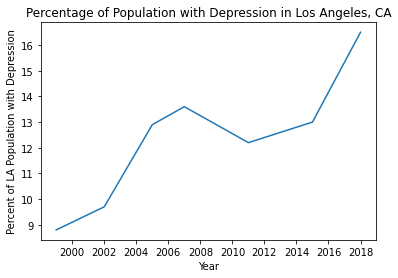

In [8]:
# Graphing Percentage of Population with Depression in Los Angeles, CA using Seaborn lineplot and renaming axes to be more descriptive
sns.lineplot(data=overall, x='year', y='population_depression_diagnosis_percent').set(
    title="Percentage of Population with Depression in Los Angeles, CA", xlabel="Year", ylabel="Percent of LA Population with Depression")
f1 = plt.gcf()
plt.show()

The figure above is a line chart displaying the percent of the population in Los Angeles, CA that has a diagnosis of depression in a particular year. Althhough there was a brief decline in the percent of the LA population diagnosed with depression between 2007 and 2011, the overall trend has been a significant overall increase from about 9% of the population in 2000 to over 16% of the population in 2018.
<br></br>
Below we have graphed a more thorough breakdown of depression rates by district in LA over time. The legend is not provided because of the number of districts; the main point we see from this graph is that depression rates have generally been increasing over time for nearly all of LA's healthcare districts.

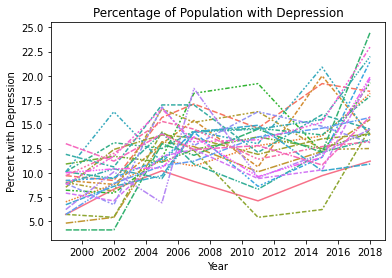

In [9]:
# Graphing Depression Rates in LA Health Districts using Seaborn lineplot and renaming axes to be more descriptive

# setting years as indices to make graphing wideform data easier
df4_graph = df4.iloc[:, 2:]
df4_graph.index = df4.year

# creating figure
sns.lineplot(data=df4_graph, legend=False).set(
    title="Percentage of Population with Depression", xlabel="Year", ylabel="Percent with Depression")
f1 = plt.gcf()
plt.show()

In [10]:
# potential to-dos:
# LINEAR REGRESSION ON POPULATION PER CITY X DEPRESSION RATES OF CITIES
# GRAPH LOS ANGELES POPULATION AS A WHOLE, BY THE SUM OF LA POPULATION DEPRESSION RATES

# check for california population density correlation to california mental health data sets as a whole?
 # then from here narrow into Los Angeles data
 # calculate population density of each city
 # compare density with depression

        



# FIX QUALITY OF GRAPHS / make bigger?
# CREATE MAP WITH LA CITIES AND CORRESPONDING DEPRESSION HOT SPOTS
